In [11]:
import SimpleITK as sitk
import nibabel as nib

from copy import deepcopy

import glob
import shutil
import numpy as np
import pandas as pd
from collections import OrderedDict
from multiprocessing import Pool

import json
from PIL import Image
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader

# from generic_UNet import Generic_UNet



# Exploratory Data Analysis

In [2]:
path = "C:/Users/z1023/WorkSpace/biomedical/nnUNet-master/nnUNetFrame/nnUNet_raw/nnUNet_raw_data/Task027_ACDC"

nnUNet以npz格式储存img_array，以pkl格式储存spacing，size，origin等properties。

In [3]:
img_origin = sitk.ReadImage(os.path.join(path,'imagesTr/patient001_frame01_0000.nii.gz'))
img_array = sitk.GetArrayFromImage(img_origin)

In [4]:
spacing = img_origin.GetSpacing()
print(spacing)

(1.5625, 1.5625, 10.0)


In [5]:
size = img_origin.GetSize()
print(size) # (Width, Height, Depth)

(216, 256, 10)


In [6]:
origin = img_origin.GetOrigin()
print(origin)

(0.0, 0.0, 0.0)


In [7]:
direction = img_origin.GetDirection()
print(direction)

(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)


In [8]:
print(img_array.shape) # (Depth, Height, Width)

(10, 256, 216)

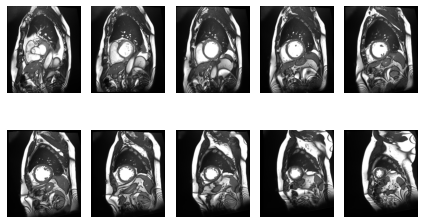

In [50]:
fig, ax = plt.subplots(2, 5)
for i in range(10):
    t = Image.fromarray(img_array[i,:,:])
    ax[i//5,i%5].axis('off')
    ax[i//5,i%5].imshow(t, cmap='gray')
fig.tight_layout()
plt.show()

In [93]:
seg_array = sitk.ReadImage(os.path.join(path,'./labelsTr/patient001_frame01.nii.gz'))
seg_array = sitk.GetArrayFromImage(seg_array)

In [47]:
seg_array.shape

(10, 256, 216)

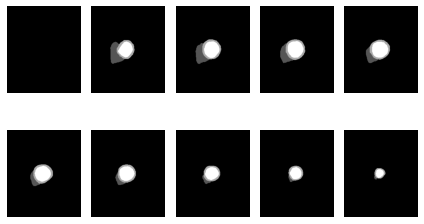

In [51]:
fig, ax = plt.subplots(2, 5)
for i in range(10):
    t = Image.fromarray(seg_array[i,:,:])
    ax[i//5,i%5].axis('off')
    ax[i//5,i%5].imshow(t, cmap='gray')
fig.tight_layout()
plt.show()

In [52]:
def get_array_from_nii(nii_file):
    array = sitk.ReadImage(nii_file)
    array = sitk.GetArrayFromImage(array)
    return array

In [25]:
def visualize_array(array):
    depth = array.shape[0]    
    fig, ax = plt.subplots(depth//5+1, 5)
    for i in range(depth):
        t = Image.fromarray(array[i,:,:])
        ax[i//5,i%5].axis('off')
        ax[i//5,i%5].imshow(t, cmap='gray')
    fig.tight_layout()
    plt.show()

In [54]:
array = get_array_from_nii(os.path.join(path,'./imagesTs/patient101_frame01_0000.nii.gz'))
array.shape

(10, 256, 232)

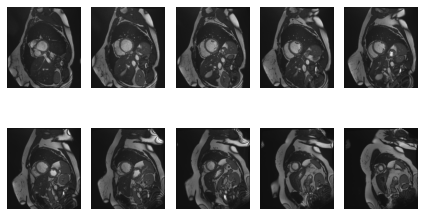

In [58]:
visualize_array(array)

In [80]:
def get_file_list(dir_path):
    filenames = os.listdir(os.path.join(dir_path))
    filelist = []
    for filename in filenames:
        filelist.append(os.path.join(dir_path,filename))
    return filelist

In [81]:
image_list = get_file_list(os.path.join(path,'imagesTr'))
label_list = get_file_list(os.path.join(path,'labelsTr'))
assert len(image_list) == len(label_list)

In [82]:
for i in image_list[:10]:
    array = get_array_from_nii(i)
    print(array.shape)

(8, 304, 216)
(8, 304, 216)
(16, 224, 154)
(16, 224, 154)
(7, 256, 216)
(7, 256, 216)
(8, 256, 216)
(8, 256, 216)
(18, 208, 174)
(18, 208, 174)


# Analyze Dataset

In [ ]:
def get_voxels_in_foreground(image_path, modality_id):
    all_data = np.load(image_path)['data']
    modality = all_data[modality_id]
    mask = all_data[-1] > 0
    voxels = list(modality[mask][::10]) # no need to take every voxel
    return voxels

def compute_stats(voxels):
    if len(voxels) == 0:
        return np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, np.nan
    median = np.median(voxels)
    mean = np.mean(voxels)
    sd = np.std(voxels)
    mn = np.min(voxels)
    mx = np.max(voxels)
    percentile_99_5 = np.percentile(voxels, 99.5)
    percentile_00_5 = np.percentile(voxels, 00.5)
    return median, mean, sd, mn, mx, percentile_99_5, percentile_00_5

def collect_intensity_properties(dataset_folder, num_modalities):
    p = Pool(8)
    image_list = glob.glob(os.path.join(dataset_folder, "imagesTr", "*.nii.gz"))

    results = OrderedDict()
    for mod_id in range(num_modalities):
        results[mod_id] = OrderedDict()
        v = p.starmap(get_voxels_in_foreground, zip(image_list,
                                                        [mod_id] * len(image_list)))

        w = []
        for iv in v:
            w += iv

        median, mean, sd, mn, mx, percentile_99_5, percentile_00_5 = compute_stats(w)

        local_props = p.map(compute_stats, v)
        props_per_case = OrderedDict()
        for i, pat in enumerate(image_list):
            props_per_case[pat] = OrderedDict()
            props_per_case[pat]['median'] = local_props[i][0]
            props_per_case[pat]['mean'] = local_props[i][1]
            props_per_case[pat]['sd'] = local_props[i][2]
            props_per_case[pat]['mn'] = local_props[i][3]
            props_per_case[pat]['mx'] = local_props[i][4]
            props_per_case[pat]['percentile_99_5'] = local_props[i][5]
            props_per_case[pat]['percentile_00_5'] = local_props[i][6]

        results[mod_id]['local_props'] = props_per_case
        results[mod_id]['median'] = median
        results[mod_id]['mean'] = mean
        results[mod_id]['sd'] = sd
        results[mod_id]['mn'] = mn
        results[mod_id]['mx'] = mx
        results[mod_id]['percentile_99_5'] = percentile_99_5
        results[mod_id]['percentile_00_5'] = percentile_00_5

    p.close()
    p.join()

    return results

In [56]:
def analyze_dataset(dataset_folder):
    dataset_json_path = os.path.join(dataset_folder, 'dataset.json')
    dataset_json = None
    with open(dataset_json_path, 'r') as f:
        dataset_json = json.load(f)
        
    dataset_properties = {}
    
    # different types of segmentation areas; 0 is background area
    classes = dataset_json['labels']
    dataset_properties['all_classes'] = [int(i) for i in classes.keys() if int(i) > 0]
    
    # sizes & spacings of each sample
    image_list = glob.glob(os.path.join(dataset_folder, "imagesTr", "*.nii.gz"))
    dataset_properties['all_sizes'] = [sitk.ReadImage(image).GetSize() for image in image_list]
    dataset_properties['all_spacings'] = [sitk.ReadImage(image).GetSpacing() for image in image_list]
    dataset_properties['num_cases'] = len(image_list)
    
    # modalities
    modalities = dataset_json["modality"]
    dataset_properties['modalities'] = {int(k): modalities[k] for k in modalities.keys()}
    
    # TODO: intensity_properties & size_reduction
    
    
    return dataset_properties

In [57]:
dataset_properties = analyze_dataset(path)
print(dataset_properties.keys())

dict_keys(['all_classes', 'all_sizes', 'all_spacings', 'num_cases', 'modalities'])


# Generate Plans

In [58]:
generated_plans_for_3dfullres = pd.read_pickle('plans.pkl')
# print(generated_plans_for_3dfullres.keys())
print(generated_plans_for_3dfullres['plans_per_stage'][0])

{'batch_size': 3, 'num_pool_per_axis': [2, 5, 5], 'patch_size': array([ 20, 256, 224], dtype=int64), 'median_patient_size_in_voxels': array([ 18, 237, 208], dtype=int64), 'current_spacing': array([5.    , 1.5625, 1.5625]), 'original_spacing': array([5.    , 1.5625, 1.5625]), 'do_dummy_2D_data_aug': True, 'pool_op_kernel_sizes': [[1, 2, 2], [2, 2, 2], [2, 2, 2], [1, 2, 2], [1, 2, 2]], 'conv_kernel_sizes': [[1, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]}


In [59]:
def get_shape_must_be_divisible_by(net_numpool_per_axis):
    return 2 ** np.array(net_numpool_per_axis)

def pad_shape(shape, must_be_divisible_by):
    """
    pads shape so that it is divisibly by must_be_divisible_by
    :param shape:
    :param must_be_divisible_by:
    :return:
    """
    if not isinstance(must_be_divisible_by, (tuple, list, np.ndarray)):
        must_be_divisible_by = [must_be_divisible_by] * len(shape)
    else:
        assert len(must_be_divisible_by) == len(shape)

    new_shp = [shape[i] + must_be_divisible_by[i] - shape[i] % must_be_divisible_by[i] for i in range(len(shape))]

    for i in range(len(shape)):
        if shape[i] % must_be_divisible_by[i] == 0:
            new_shp[i] -= must_be_divisible_by[i]
    new_shp = np.array(new_shp).astype(int)
    return new_shp

In [73]:
def get_pool_and_conv_props(spacing, patch_size, min_feature_map_size, max_numpool):
    """
    :param spacing:
    :param patch_size:
    :param min_feature_map_size: min edge length of feature maps in bottleneck
    :return:
    """
    dim = len(spacing)

    current_spacing = deepcopy(list(spacing))
    current_size = deepcopy(list(patch_size))

    pool_op_kernel_sizes = []
    conv_kernel_sizes = []

    num_pool_per_axis = [0] * dim

    while True:
        # This is a problem because sometimes we have spacing 20, 50, 50 and we want to still keep pooling.
        # Here we would stop however. This is not what we want! Fixed in get_pool_and_conv_propsv2
        min_spacing = min(current_spacing)
        valid_axes_for_pool = [i for i in range(dim) if current_spacing[i] / min_spacing < 2]
        axes = []
        for a in range(dim):
            my_spacing = current_spacing[a]
            partners = [i for i in range(dim) if current_spacing[i] / my_spacing < 2 and my_spacing / current_spacing[i] < 2]
            if len(partners) > len(axes):
                axes = partners
        conv_kernel_size = [3 if i in axes else 1 for i in range(dim)]

        # exclude axes that we cannot pool further because of min_feature_map_size constraint
        #before = len(valid_axes_for_pool)
        valid_axes_for_pool = [i for i in valid_axes_for_pool if current_size[i] >= 2*min_feature_map_size]
        #after = len(valid_axes_for_pool)
        #if after == 1 and before > 1:
        #    break

        valid_axes_for_pool = [i for i in valid_axes_for_pool if num_pool_per_axis[i] < max_numpool]

        if len(valid_axes_for_pool) == 0:
            break

        #print(current_spacing, current_size)

        other_axes = [i for i in range(dim) if i not in valid_axes_for_pool]

        pool_kernel_sizes = [0] * dim
        for v in valid_axes_for_pool:
            pool_kernel_sizes[v] = 2
            num_pool_per_axis[v] += 1
            current_spacing[v] *= 2
            current_size[v] = np.ceil(current_size[v] / 2)
        for nv in other_axes:
            pool_kernel_sizes[nv] = 1

        pool_op_kernel_sizes.append(pool_kernel_sizes)
        conv_kernel_sizes.append(conv_kernel_size)
        #print(conv_kernel_sizes)

    must_be_divisible_by = get_shape_must_be_divisible_by(num_pool_per_axis)
    patch_size = pad_shape(patch_size, must_be_divisible_by)

    # we need to add one more conv_kernel_size for the bottleneck. We always use 3x3(x3) conv here
    conv_kernel_sizes.append([3]*dim)
    return num_pool_per_axis, pool_op_kernel_sizes, conv_kernel_sizes, patch_size, must_be_divisible_by


def get_properties_for_stage(current_spacing, original_spacing, original_shape, num_cases,
                                 num_modalities, num_classes):
        """
        ExperimentPlanner configures pooling so that we pool late. Meaning that if the number of pooling per axis is
        (2, 3, 3), then the first pooling operation will always pool axes 1 and 2 and not 0, irrespective of spacing.
        This can cause a larger memory footprint, so it can be beneficial to revise this.

        Here we are pooling based on the spacing of the data.

        """
        unet_featuremap_min_edge_length = 4
        unet_max_numpool = 999
        unet_max_num_filters = 320
        unet_base_num_features = Generic_UNet.BASE_NUM_FEATURES_3D
        conv_per_stage = 2
        batch_size_covers_max_percent_of_dataset = 0.05
        unet_min_batch_size = 2
        anisotropy_threshold = 3
        
        new_median_shape = np.round(original_spacing / current_spacing * original_shape).astype(int)
        dataset_num_voxels = np.prod(new_median_shape) * num_cases

        # compute how many voxels are one mm
        input_patch_size = 1 / np.array(current_spacing)

        # normalize voxels per mm
        input_patch_size /= input_patch_size.mean()

        # create an isotropic patch of size 512x512x512mm
        input_patch_size *= 1 / min(input_patch_size) * 512  # to get a starting value
        input_patch_size = np.round(input_patch_size).astype(int)

        # clip it to the median shape of the dataset because patches larger then that make not much sense
        input_patch_size = [min(i, j) for i, j in zip(input_patch_size, new_median_shape)]

        network_num_pool_per_axis, pool_op_kernel_sizes, conv_kernel_sizes, new_shp, \
        shape_must_be_divisible_by = get_pool_and_conv_props(current_spacing, input_patch_size,
                                                            unet_featuremap_min_edge_length,
                                                             unet_max_numpool)

        # we compute as if we were using only 30 feature maps. We can do that because fp16 training is the standard
        # now. That frees up some space. The decision to go with 32 is solely due to the speedup we get (non-multiples
        # of 8 are not supported in nvidia amp)
        ref = Generic_UNet.use_this_for_batch_size_computation_3D * unet_base_num_features / \
              Generic_UNet.BASE_NUM_FEATURES_3D
        here = Generic_UNet.compute_approx_vram_consumption(new_shp, network_num_pool_per_axis,
                                                            unet_base_num_features,
                                                            unet_max_num_filters, num_modalities,
                                                            num_classes,
                                                            pool_op_kernel_sizes, conv_per_stage=conv_per_stage)
        while here > ref:
            axis_to_be_reduced = np.argsort(new_shp / new_median_shape)[-1]

            tmp = deepcopy(new_shp)
            tmp[axis_to_be_reduced] -= shape_must_be_divisible_by[axis_to_be_reduced]
            _, _, _, _, shape_must_be_divisible_by_new = \
                get_pool_and_conv_props(current_spacing, tmp,
                                        unet_featuremap_min_edge_length,
                                        unet_max_numpool,
                                        )
            new_shp[axis_to_be_reduced] -= shape_must_be_divisible_by_new[axis_to_be_reduced]

            # we have to recompute numpool now:
            network_num_pool_per_axis, pool_op_kernel_sizes, conv_kernel_sizes, new_shp, \
            shape_must_be_divisible_by = get_pool_and_conv_props(current_spacing, new_shp,
                                                                 unet_featuremap_min_edge_length,
                                                                 unet_max_numpool,
                                                                 )

            here = Generic_UNet.compute_approx_vram_consumption(new_shp, network_num_pool_per_axis,
                                                                unet_base_num_features,
                                                                unet_max_num_filters, num_modalities,
                                                                num_classes, pool_op_kernel_sizes,
                                                                conv_per_stage=conv_per_stage)
            #print(new_shp)
        #print(here, ref)

        input_patch_size = new_shp

        batch_size = Generic_UNet.DEFAULT_BATCH_SIZE_3D  # This is what wirks with 128**3
        batch_size = int(np.floor(max(ref / here, 1) * batch_size))

        # check if batch size is too large
        max_batch_size = np.round(batch_size_covers_max_percent_of_dataset * dataset_num_voxels /
                                  np.prod(input_patch_size, dtype=np.int64)).astype(int)
        max_batch_size = max(max_batch_size, unet_min_batch_size)
        batch_size = max(1, min(batch_size, max_batch_size))

        do_dummy_2D_data_aug = (max(input_patch_size) / input_patch_size[
            0]) > anisotropy_threshold

        plan = {
            'batch_size': batch_size,
            'num_pool_per_axis': network_num_pool_per_axis,
            'patch_size': input_patch_size,
            'median_patient_size_in_voxels': new_median_shape,
            'current_spacing': current_spacing,
            'original_spacing': original_spacing,
            'do_dummy_2D_data_aug': do_dummy_2D_data_aug,
            'pool_op_kernel_sizes': pool_op_kernel_sizes,
            'conv_kernel_sizes': conv_kernel_sizes,
        }
        return plan
 

In [88]:

def generate_plans(dataset_properties, preprocessed_output_folder):
    # get dataset properties
    spacings = dataset_properties['all_spacings']
    sizes = dataset_properties['all_sizes']
    all_classes = dataset_properties['all_classes']
    modalities = dataset_properties['modalities']
    num_cases = dataset_properties['num_cases']
    num_modalities = len(list(modalities.keys()))
    
    # TODO: 
    # we don't use mask for normalization 'cause we don't crop, 
    # and we'll consider it later once we crop
    
    # different strides for spacing anisotropy
    target_spacing = np.median(spacings, 0)
    max_spacing_axis = np.argmax(target_spacing)
    remaining_axes = [i for i in list(range(3)) if i != max_spacing_axis]
    transpose_forward = [max_spacing_axis] + remaining_axes
    transpose_backward = [np.argwhere(np.array(transpose_forward) == i)[0][0] for i in range(3)]
    
    # analysis new shapes
    # shape = spacing x resolution
    print("analyzing new shapes")
    new_shapes = [np.array(i) / target_spacing * np.array(j) for i, j in zip(spacings, sizes)]
    median_shape = np.median(np.vstack(new_shapes), 0)
    target_spacing_transposed = np.array(target_spacing)[transpose_forward]
    median_shape_transposed = np.array(median_shape)[transpose_forward]
    
    # generate plans per stage
    print("generating configuration for 3d_fullres")
    plans_per_stage = list()
    plans_per_stage.append(get_properties_for_stage(target_spacing_transposed, target_spacing_transposed,
                                                                  median_shape_transposed,
                                                                  num_cases,
                                                                  num_modalities, len(all_classes) + 1))
    
    # thanks Zakiyi (https://github.com/MIC-DKFZ/nnUNet/issues/61) for spotting this bug :-)
    # if np.prod(self.plans_per_stage[-1]['median_patient_size_in_voxels'], dtype=np.int64) / \
    #        architecture_input_voxels < HOW_MUCH_OF_A_PATIENT_MUST_THE_NETWORK_SEE_AT_STAGE0:
    how_much_of_a_patient_must_the_network_see_at_stage0 = 4
    architecture_input_voxels_here = np.prod(plans_per_stage[-1]['patch_size'], dtype=np.int64)
    if np.prod(median_shape) / architecture_input_voxels_here < \
            how_much_of_a_patient_must_the_network_see_at_stage0:
        more = False
    else:
        more = True

    if more:
        print("generating configuration for 3d_lowres")
        # if we are doing more than one stage then we want the lowest stage to have exactly
        # HOW_MUCH_OF_A_PATIENT_MUST_THE_NETWORK_SEE_AT_STAGE0 (this is 4 by default so the number of voxels in the
        # median shape of the lowest stage must be 4 times as much as the network can process at once (128x128x128 by
        # default). Problem is that we are downsampling higher resolution axes before we start downsampling the
        # out-of-plane axis. We could probably/maybe do this analytically but I am lazy, so here
        # we do it the dumb way

        lowres_stage_spacing = deepcopy(target_spacing)
        num_voxels = np.prod(median_shape, dtype=np.float64)
        while num_voxels > how_much_of_a_patient_must_the_network_see_at_stage0 * architecture_input_voxels_here:
            max_spacing = max(lowres_stage_spacing)
            if np.any((max_spacing / lowres_stage_spacing) > 2):
                lowres_stage_spacing[(max_spacing / lowres_stage_spacing) > 2] \
                    *= 1.01
            else:
                lowres_stage_spacing *= 1.01
            num_voxels = np.prod(target_spacing / lowres_stage_spacing * median_shape, dtype=np.float64)

            lowres_stage_spacing_transposed = np.array(lowres_stage_spacing)[self.transpose_forward]
            new = get_properties_for_stage(lowres_stage_spacing_transposed, target_spacing_transposed,
                                                median_shape_transposed,
                                                num_cases,
                                                num_modalities, len(all_classes) + 1)
            architecture_input_voxels_here = np.prod(new['patch_size'], dtype=np.int64)
        if 2 * np.prod(new['median_patient_size_in_voxels'], dtype=np.int64) < np.prod(
                plans_per_stage[0]['median_patient_size_in_voxels'], dtype=np.int64):
            plans_per_stage.append(new)

    plans_per_stage = plans_per_stage[::-1]
    plans_per_stage = {i: plans_per_stage[i] for i in range(len(plans_per_stage))}  # convert to dict

    print(plans_per_stage)
    print("transpose forward", transpose_forward)
    print("transpose backward", transpose_backward)

    
    plans = {
            # data properties
                'dataset_properties': dataset_properties, 
                'num_modalities': num_modalities,
                'all_classes': all_classes, 
                'modalities': modalities,  
                'num_classes': len(all_classes),
                'num_cases': num_cases,
                
            # 'normalization_schemes': normalization_schemes,                            
            #  'list_of_npz_files': self.list_of_cropped_npz_files, 
            #  'original_spacings': spacings, 'original_sizes': sizes,
            #  'use_mask_for_norm': use_nonzero_mask_for_normalization,
            
            # fixed names & hyperparameters
                'preprocessor_name': 'GenericPreprocessor',
                'data_identifier': 'nnUNetData_plans_v2.1', 
                'preprocessed_data_folder': preprocessed_output_folder, 
                'conv_per_stage': 2,
                'base_num_features': 32, # same as ExperimentPlanner Ver. 2.1
            
            # placeholders
                'keep_only_largest_region': None,
                'min_region_size_per_class': None, 
                'min_size_per_class': None,
                
            # target spacing 
                'transpose_forward': transpose_forward, 
                'transpose_backward': transpose_backward,
                
            # neural network architecture
                'num_stages': len(list(plans_per_stage.keys())), 
                'plans_per_stage': plans_per_stage,
            }
    return plans



In [89]:
spacings = dataset_properties['all_spacings']
sizes = dataset_properties['all_sizes']
target_spacing = np.median(np.vstack(spacings), 0)
max_spacing_axis = np.argmax(target_spacing)
remaining_axes = [i for i in list(range(3)) if i != max_spacing_axis]

transpose_forward = [max_spacing_axis] + remaining_axes
transpose_backward = [np.argwhere(np.array(transpose_forward) == i)[0][0] for i in range(3)]
new_shapes = [np.array(i) / target_spacing * np.array(j) for i, j in zip(spacings, sizes)]
median_shape = np.median(np.vstack(new_shapes), 0)
target_spacing_transposed = np.array(target_spacing)[transpose_forward]
median_shape_transposed = np.array(median_shape)[transpose_forward]
# print(target_spacing)
# print(transpose_forward)
# print(transpose_backward)
# i = 3
# print(spacings[3])
# print(sizes[3])
# print(target_spacing)
# print(new_shapes[3])
print(median_shape)
print(target_spacing_transposed)
print(median_shape_transposed)

[208.  236.8   9. ]
[10.      1.5625  1.5625]
[  9.  208.  236.8]


In [87]:
plan = generate_plans(dataset_properties)

analyzing new shapes
generating configuration for 3d_fullres
{0: {'batch_size': 6, 'num_pool_per_axis': [1, 5, 5], 'patch_size': array([ 10, 224, 256]), 'median_patient_size_in_voxels': array([  9, 208, 237]), 'current_spacing': array([10.    ,  1.5625,  1.5625]), 'original_spacing': array([10.    ,  1.5625,  1.5625]), 'do_dummy_2D_data_aug': True, 'pool_op_kernel_sizes': [[1, 2, 2], [1, 2, 2], [2, 2, 2], [1, 2, 2], [1, 2, 2]], 'conv_kernel_sizes': [[1, 3, 3], [1, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3], [3, 3, 3]]}}
transpose forward [2, 0, 1]
transpose backward [1, 2, 0]


NameError: name 'preprocessed_output_folder' is not defined

# Preprocessing

In [ ]:
def run_preprocessing(plans,folder_with_cropped_data,preprocessed_output_folder,num_threads=8):
    if os.path.isdir(os.path.join(preprocessed_output_folder, "gt_segmentations")):
        shutil.rmtree(os.path.join(preprocessed_output_folder, "gt_segmentations"))
    shutil.copytree(os.path.join(folder_with_cropped_data, "gt_segmentations"),
                    os.path.join(preprocessed_output_folder, "gt_segmentations"))
    normalization_schemes = 'nonCT'
    use_nonzero_mask_for_normalization = False
    intensityproperties = None
    preprocessor = GenericPreprocessor(normalization_schemes, use_nonzero_mask_for_normalization,
                                        plans['transpose_forward'],
                                        intensityproperties)
    target_spacings = [i["current_spacing"] for i in plans['plans_per_stage'].values()]
    num_threads = num_threads[-1]
    preprocessor.run(target_spacings, folder_with_cropped_data, preprocessed_output_folder,
                        plans['data_identifier'], num_threads)

In [ ]:
class GenericPreprocessor(object):
    def __init__(self, normalization_scheme_per_modality, use_nonzero_mask, transpose_forward, intensityproperties=None):
        """

        :param normalization_scheme_per_modality: dict {0:'nonCT'}
        :param use_nonzero_mask: {0:False}
        :param intensityproperties:
        """
        self.transpose_forward = transpose_forward
        self.intensityproperties = intensityproperties
        self.normalization_scheme_per_modality = normalization_scheme_per_modality
        self.use_nonzero_mask = use_nonzero_mask

        self.resample_separate_z_anisotropy_threshold = RESAMPLING_SEPARATE_Z_ANISO_THRESHOLD

    @staticmethod
    def load_cropped(cropped_output_dir, case_identifier):
        all_data = np.load(os.path.join(cropped_output_dir, "%s.npz" % case_identifier))['data']
        data = all_data[:-1].astype(np.float32)
        seg = all_data[-1:]
        with open(os.path.join(cropped_output_dir, "%s.pkl" % case_identifier), 'rb') as f:
            properties = pickle.load(f)
        return data, seg, properties

    def resample_and_normalize(self, data, target_spacing, properties, seg=None, force_separate_z=None):
        """
        data and seg must already have been transposed by transpose_forward. properties are the un-transposed values
        (spacing etc)
        :param data:
        :param target_spacing:
        :param properties:
        :param seg:
        :param force_separate_z:
        :return:
        """

        # target_spacing is already transposed, properties["original_spacing"] is not so we need to transpose it!
        # data, seg are already transposed. Double check this using the properties
        original_spacing_transposed = np.array(properties["original_spacing"])[self.transpose_forward]
        before = {
            'spacing': properties["original_spacing"],
            'spacing_transposed': original_spacing_transposed,
            'data.shape (data is transposed)': data.shape
        }

        # remove nans
        data[np.isnan(data)] = 0

        data, seg = resample_patient(data, seg, np.array(original_spacing_transposed), target_spacing, 3, 1,
                                     force_separate_z=force_separate_z, order_z_data=0, order_z_seg=0,
                                     separate_z_anisotropy_threshold=self.resample_separate_z_anisotropy_threshold)
        after = {
            'spacing': target_spacing,
            'data.shape (data is resampled)': data.shape
        }
        print("before:", before, "\nafter: ", after, "\n")

        if seg is not None:  # hippocampus 243 has one voxel with -2 as label. wtf?
            seg[seg < -1] = 0

        properties["size_after_resampling"] = data[0].shape
        properties["spacing_after_resampling"] = target_spacing
        use_nonzero_mask = self.use_nonzero_mask

        assert len(self.normalization_scheme_per_modality) == len(data), "self.normalization_scheme_per_modality " \
                                                                         "must have as many entries as data has " \
                                                                         "modalities"
        assert len(self.use_nonzero_mask) == len(data), "self.use_nonzero_mask must have as many entries as data" \
                                                        " has modalities"

        for c in range(len(data)):
            scheme = self.normalization_scheme_per_modality[c]
            if use_nonzero_mask[c]:
                mask = seg[-1] >= 0
                data[c][mask] = (data[c][mask] - data[c][mask].mean()) / (data[c][mask].std() + 1e-8)
                data[c][mask == 0] = 0
            else:
                mn = data[c].mean()
                std = data[c].std()
                # print(data[c].shape, data[c].dtype, mn, std)
                data[c] = (data[c] - mn) / (std + 1e-8)
        return data, seg, properties

    def preprocess_test_case(self, data_files, target_spacing, seg_file=None, force_separate_z=None):
        data, seg, properties = ImageCropper.crop_from_list_of_files(data_files, seg_file)

        data = data.transpose((0, *[i + 1 for i in self.transpose_forward]))
        seg = seg.transpose((0, *[i + 1 for i in self.transpose_forward]))

        data, seg, properties = self.resample_and_normalize(data, target_spacing, properties, seg,
                                                            force_separate_z=force_separate_z)
        return data.astype(np.float32), seg, properties

    def _run_internal(self, target_spacing, case_identifier, output_folder_stage, cropped_output_dir, force_separate_z,
                      all_classes):
        data, seg, properties = self.load_cropped(cropped_output_dir, case_identifier)

        data = data.transpose((0, *[i + 1 for i in self.transpose_forward]))
        seg = seg.transpose((0, *[i + 1 for i in self.transpose_forward]))

        data, seg, properties = self.resample_and_normalize(data, target_spacing,
                                                            properties, seg, force_separate_z)

        all_data = np.vstack((data, seg)).astype(np.float32)

        # we need to find out where the classes are and sample some random locations
        # let's do 10.000 samples per class
        # seed this for reproducibility!
        num_samples = 10000
        min_percent_coverage = 0.01 # at least 1% of the class voxels need to be selected, otherwise it may be too sparse
        rndst = np.random.RandomState(1234)
        class_locs = {}
        for c in all_classes:
            all_locs = np.argwhere(all_data[-1] == c)
            if len(all_locs) == 0:
                class_locs[c] = []
                continue
            target_num_samples = min(num_samples, len(all_locs))
            target_num_samples = max(target_num_samples, int(np.ceil(len(all_locs) * min_percent_coverage)))

            selected = all_locs[rndst.choice(len(all_locs), target_num_samples, replace=False)]
            class_locs[c] = selected
            print(c, target_num_samples)
        properties['class_locations'] = class_locs

        print("saving: ", os.path.join(output_folder_stage, "%s.npz" % case_identifier))
        np.savez_compressed(os.path.join(output_folder_stage, "%s.npz" % case_identifier),
                            data=all_data.astype(np.float32))
        with open(os.path.join(output_folder_stage, "%s.pkl" % case_identifier), 'wb') as f:
            pickle.dump(properties, f)

    def run(self, target_spacings, input_folder_with_cropped_npz, output_folder, data_identifier,
            num_threads=8, force_separate_z=None):
        """

        :param target_spacings: list of lists [[1.25, 1.25, 5]]
        :param input_folder_with_cropped_npz: dim: c, x, y, z | npz_file['data'] np.savez_compressed(fname.npz, data=arr)
        :param output_folder:
        :param num_threads:
        :param force_separate_z: None
        :return:
        """
        print("Initializing to run preprocessing")
        print("npz folder:", input_folder_with_cropped_npz)
        print("output_folder:", output_folder)
        list_of_cropped_npz_files = subfiles(input_folder_with_cropped_npz, True, None, ".npz", True)
        maybe_mkdir_p(output_folder)
        num_stages = len(target_spacings)
        if not isinstance(num_threads, (list, tuple, np.ndarray)):
            num_threads = [num_threads] * num_stages

        assert len(num_threads) == num_stages

        # we need to know which classes are present in this dataset so that we can precompute where these classes are
        # located. This is needed for oversampling foreground
        all_classes = load_pickle(join(input_folder_with_cropped_npz, 'dataset_properties.pkl'))['all_classes']

        for i in range(num_stages):
            all_args = []
            output_folder_stage = os.path.join(output_folder, data_identifier + "_stage%d" % i)
            maybe_mkdir_p(output_folder_stage)
            spacing = target_spacings[i]
            for j, case in enumerate(list_of_cropped_npz_files):
                case_identifier = get_case_identifier_from_npz(case)
                args = spacing, case_identifier, output_folder_stage, input_folder_with_cropped_npz, force_separate_z, all_classes
                all_args.append(args)
            p = Pool(num_threads[i])
            p.starmap(self._run_internal, all_args)
            p.close()
            p.join()


# Model

(10, 256, 216)

# Dataset

In [ ]:
class ACDCDataset(Dataset):
    def __init__(self, image_list, label_list, data_json_path, transform):
        self.image_list = image_list
        self.label_list = label_list
        with open(data_json_path, 'r') as f:
            self.data_json = json.load(f)
        self.transform = transform
        
        
    def __getitem__(self, index):
        image_path = self.image_list[index]
        label_path = self.label_list[index]
        
        image_array = self._get_array_from_nii(image_path).astype(np.float32) # [depth, heigth, width]
        label_array = self._get_array_from_nii(image_path) # [depth, heigth, width]
        
        image_array = torch.FloatTensor()
        
        return image_array, label_array
        
    def _get_array_from_nii(nii_file):
        array = sitk.ReadImage(nii_file)
        array = sitk.GetArrayFromImage(array)
        return array
    
    def _analyze_dataset():
        return None
    
    def __len__():
        return len(image_list)

# Evaluate

## 1
no normalization
no dropout
brutal crop to 224x224
2D UNet

In [143]:
from pickletools import optimize
import tqdm
from model import UNet2D
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from dataset import ACDCDataset, collate_fn
import os
import numpy as np
from train import get_file_list

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def dice_coef(output, target):
    smooth = 1e-5
    output = torch.sigmoid(output).data.cpu().numpy()
    target = target.data.cpu().numpy()
    
    intersection = (output * target).sum()
    
    return (2. * intersection + smooth)/ \
        (output.sum() + target.sum() + smooth)
    
def evaluate(dataloader, model, checkpoint_path):
    model.to(device)
    model.eval()
    # checkpoint = torch.load(checkpoint_path)
    # model.load_state_dict(checkpoint['model'])
    
    dice_coefs = []
    
    with torch.no_grad():
        for img, target in dataloader:
            num_slices = img.shape[0]
            img = img.to(device)
            target = target.to(device).squeeze(1)
            output = model(img).squeeze(1)
            output = torch.sigmoid(output)
            dice_coefs += [dice_coef(target[i],target[i]) for i in range(num_slices)]
            return img, target, output



In [149]:

epochs = 10

path = "./Task027_ACDC"
image_list = get_file_list(os.path.join(path,'imagesTr'))
image_list.sort()
label_list = get_file_list(os.path.join(path,'labelsTr'))
label_list.sort()
data_json_path = os.path.join(path, "dataset.json")
dataset =  ACDCDataset(image_list, label_list, data_json_path)
dataloader = DataLoader(dataset, batch_size = 2, shuffle = True, collate_fn=collate_fn)

model = UNet2D()

image, target, output = evaluate(dataloader, model, 'checkpoint_150')


In [150]:
num_slices = image.shape[0]
image_array = image.squeeze(1).data.cpu().numpy()
target_array = target.data.cpu().numpy()
output_array = output.data.cpu().numpy()
dices = [dice_coef(target[i],target[i]) for i in range(image.shape[0])]

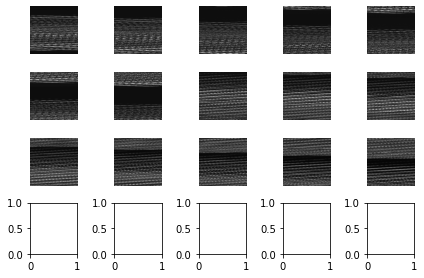

In [151]:
visualize_array(image_array*255)

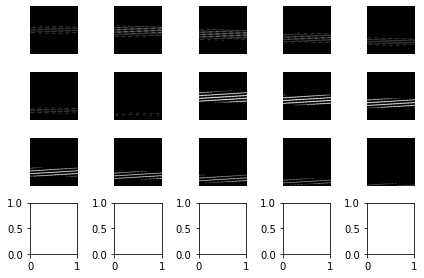

In [152]:
visualize_array(target_array*255)

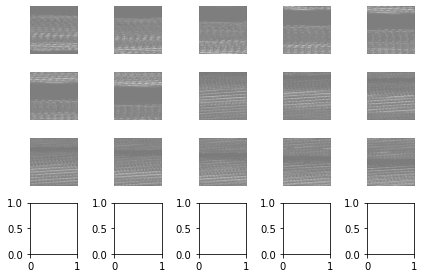

In [153]:
visualize_array(output_array*255)